In [2]:
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from sklearn import metrics
import os
import tensorflow as tf

In [3]:
from pylab import imshow
from pylab import plot

In [4]:
def prep(img):
    img = cv2.GaussianBlur(img, (31,31), 0) 
    img_p = cv2.resize(img, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    return img_p

In [5]:
def find_loc(p_img):
    maxv = 0
    imax = 0
    jmax = 0
    h = p_img.shape[0]
    w = p_img.shape[1]
    for i in range(1,h-size+1):
        for j in range(1,w-size+1):
            if i%20 == 0 and j%20 == 0:
                bimg = p_img[i:i+size, j:j+size, :]
                b,g,r = cv2.split(bimg)

                c1, b1 = np.histogram(r.ravel(), 256, [0, 256])
                c2, b2 = np.histogram(g.ravel(), 256, [0, 256])
                c3, b3 = np.histogram(b.ravel(), 256, [0, 256])

                sum1 = 0
                sum2 = 0
                sum3 = 0
                for k in range(60,240):
                    sum1 += (c1[k]-cs1[k])*(c1[k]-cs1[k])
                    sum2 += (c2[k]-cs2[k])*(c2[k]-cs2[k])
                    sum3 += (c3[k]-cs3[k])*(c3[k]-cs3[k])

                cr = 1/(1+sum1)
                cg = 1/(1+sum2)
                cb = 1/(1+sum3)

                c = cg*2 +cb + cr*0.5

                if c > maxv:
                    maxv = c
                    imax = i
                    jmax = j
    return imax,jmax

In [6]:
def template():
    cimg = cv2.imread("template/1.jpg")
    bi,gi,ri = cv2.split(cimg)
    cs1, bs1 = np.histogram(ri.ravel(), 256, [0, 256])
    cs2, bs2 = np.histogram(gi.ravel(), 256, [0, 256])
    cs3, bs3 = np.histogram(bi.ravel(), 256, [0, 256])
    for i in [2,3,4]:
        cimg = cv2.imread("template/"+str(i)+".jpg")
        bi,gi,ri = cv2.split(cimg)
        c1, b1 = np.histogram(ri.ravel(), 256, [0, 256])
        c2, b2 = np.histogram(gi.ravel(), 256, [0, 256])
        c3, b3 = np.histogram(bi.ravel(), 256, [0, 256])
        cs1 += c1
        cs2 += c2
        cs3 += c3
    cs1 = cs1/4
    cs2 = cs2/4
    cs3 = cs3/4
    
    return cs1,cs2,cs3

In [7]:
def Erosion(img):
    kernel = np.ones((21,21),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 1)
    #腐蚀
    return erosion

In [8]:
def Dilation(img):
    kernel = np.ones((21,21),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 1)
    #膨胀
    return dilation

In [9]:
def opening(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(91,91))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #开运算原理： 先腐蚀后膨胀，分离区域
    #闭运算原理： 先膨胀后腐蚀，消除孔洞
    return opening

In [10]:
def th_bingry(od_img,img):
    h = img.shape[0]
    w = img.shape[1]
    r = od_img[:,:,2]
    for i in range(2):
        r = cv2.GaussianBlur(r, (11,11), 0)
    Th = r.max()/2 + 110
    _,bnw = cv2.threshold(r, Th, 255, cv2.THRESH_BINARY)   
    bnw = Erosion(bnw)
    bnw = Erosion(bnw)
    bnw = opening(bnw)
    bnw = Dilation(bnw)
    result = np.zeros((h,w))
    result[imax:imax+bsize, jmax:jmax+bsize] = bnw
    
    return result

In [11]:
def im_th_bingry(od_img,img):
    b,g,r = cv2.split(img)
    h = img.shape[0]
    w = img.shape[1]
    r = od_img[:,:,2]
    Th = r.max()*1.47 - g.max()*1.18 + b.max()*0.8
    _,bnw = cv2.threshold(r, Th, 255, cv2.THRESH_BINARY)
    bnw = closing(bnw)
    result = np.zeros((h,w))
    result[imax:imax+bsize, jmax:jmax+bsize] = bnw
    
    return rst

In [12]:
def score(result):
    check = cv2.imread("optic_disc_segmentation_masks/IDRiD_"+ order +"_OD.tif", 0)
    _,bnw1 = cv2.threshold(result, 20, 1, cv2.THRESH_BINARY)
    _,bnw2 = cv2.threshold(check, 20, 1, cv2.THRESH_BINARY)
    bnw1 = bnw1.flatten()
    bnw2 = bnw2.flatten()
    acc = metrics.accuracy_score(bnw1, bnw2)
    pre = metrics.precision_score(bnw1, bnw2)
    rec = metrics.recall_score(bnw1, bnw2)
    
    return acc,pre,rec

In [15]:
#################################################main function#################################################
cs1,cs2,cs3 = template()
size = 400
bsize = 800
sumacc = 0
sumpr = 0
sumrc = 0
for order in range(1,55):
    zero = ''
    if order < 10:
        zero = '0'
    order = zero + str(order)
    img = cv2.imread("original_retinal_images/" + "IDRiD_" + order + '.jpg')
    pd_img = prep(img)
    i,j = find_loc(pd_img)
    imax = i*2
    jmax = j*2
    od_img = img[imax:imax+bsize, jmax:jmax+bsize]
    #cv2.imwrite(order+".jpg",od_img)
    rst = th_bingry(od_img,img)
    #cv2.imwrite("rst"+ order+".jpg",rst)
    accu,pre,rc = score(rst)
    sumacc += accu
    sumpr += pre
    sumrc += rc
    print(order+": "+str(accu)+', '+str(pre)+', '+str(rc))
#imshow(img)
#plot(jmax+size/2,imax+size/2,'rX')

01: 0.9941479946650176, 0.6839668741319891, 0.9741456819559238
02: 0.9869053335412125, 0.21443940108464984, 1.0
03: 0.9893236481741573, 0.45460325693657216, 1.0
04: 0.995610218089678, 0.707997668731038, 1.0
05: 0.9904700405102298, 0.46259938116579485, 0.9981139418615095
06: 0.9767379799125859, 0.0, 0.0
07: 0.9916407527408603, 0.50307157599595, 1.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


08: 0.9831517174922438, 0.0, 0.0
09: 0.9932685479729163, 0.6829193972051115, 1.0
10: 0.9916644994392504, 0.5265084562859322, 1.0
11: 0.9833675667920929, 0.0, 0.0
12: 0.9958251666526916, 0.8488758466349503, 1.0
13: 0.9888714782827436, 0.9226464611866863, 0.6258025222351637
14: 0.998133100080706, 0.9298546294619391, 0.9681776788424568
15: 0.9775694418969059, 1.0, 0.5056120763870465
16: 0.9635241705360138, 0.0, 0.0
17: 0.9911635259883868, 0.46742241787744787, 1.0
18: 0.9957767725190759, 0.7752135634588564, 1.0
19: 0.9966002097570434, 0.8357322325915291, 0.9743324179416765
20: 0.9817347765648583, 0.9957050237079714, 0.5466117191793837
21: 0.997048940471449, 0.8723960915629935, 0.9888425375553874
22: 0.9956587759936274, 0.7131339584764976, 1.0
23: 0.9878205640512326, 0.3411063219027284, 1.0
24: 0.9827747181840097, 0.0, 0.0
25: 0.9841494063652944, 0.0, 0.0
26: 0.9957315719069679, 0.7842005688192654, 1.0
27: 0.9956462475630974, 0.9001192575964082, 0.8438678824264461
28: 0.9967742157366258, 0.

In [17]:
print('average acc: '+ str(sumacc/54) + '  average acc: '+ str(sumpr/54) + '  average recall: ' + str(sumrc/54))

average acc: 0.9901512357769711  average acc: 0.5354523001715012  average recall: 0.7543742278848016


In [ ]:
##################################################---Test---##################################################

In [45]:
##for making template
order = '54'
img = cv2.imread("original_retinal_images/" + "IDRiD_" + order + '.jpg')
pd_img = prep(img)
cv2.imwrite(order+'.jpg',pd_img)

True

In [14]:
cs1,cs2,cs3 = template()
size = 400
bsize = 800

In [15]:
order = '53'
img = cv2.imread("original_retinal_images/" + "IDRiD_" + order + '.jpg')
pd_img = prep(img)
i,j = find_loc(pd_img)
imax = i*2
jmax = j*2
od_img = img[imax:imax+bsize, jmax:jmax+bsize]
#cv2.imwrite(order+".jpg",od_img)

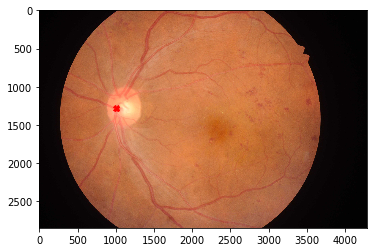

In [16]:
ss = Image.open("original_retinal_images/" + "IDRiD_" + order + '.jpg')
imshow(ss)
plot(jmax+bsize/2,imax+bsize/2,'rX')

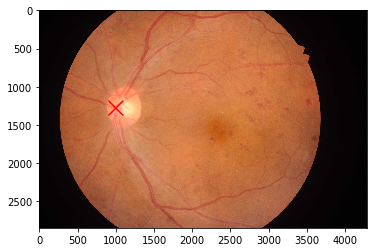

In [17]:
from skimage import draw
ss = Image.open("original_retinal_images/" + "IDRiD_" + order + '.jpg')
imshow(ss)
plot((jmax+bsize/2-90,jmax+bsize/2+90),(imax+bsize/2-90,imax+bsize/2+90),'r')
plot((jmax+bsize/2+90,jmax+bsize/2-90),(imax+bsize/2-90,imax+bsize/2+90),'r')

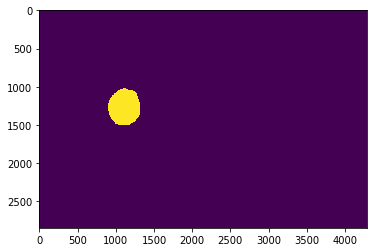

In [18]:
rst = th_bingry(od_img,img)
imshow(rst)

In [20]:
acc,pr,rc = score(rst)
print(acc,pr,rc)

0.9973962154641121 0.8345086732277522 1.0


In [105]:
###for print result and mask
check = cv2.imread("optic_disc_segmentation_masks/IDRiD_"+ order +"_OD.tif", 0)
_,c = cv2.threshold(check, 20, 1, cv2.THRESH_BINARY)
d = np.hstack((rst1,rst2,c)) 
imshow(d)